In [1]:
%matplotlib inline

In [2]:
from thetis import *
from firedrake_adjoint import *

In [3]:
import adolc

In [4]:
from adapt_utils.case_studies.tohoku.options import TohokuOkadaOptions
from adapt_utils.unsteady.solver import AdaptiveProblem
from adapt_utils.unsteady.solver_adjoint import AdaptiveDiscreteAdjointProblem

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Computing the gradient of timeseries misfit w.r.t. Okada parameters

In this work we compute gradients of quantities of interest of the form

$$
    J(\mathbf u,\eta;\mathbf m)
    =\int_0^T\int_\Omega\sum_{g\in\mathcal G}\mathbb1_g(\eta-\eta_g)^2\;\mathrm dx\;\mathrm dt,
$$

where $\mathcal G$ is a set of gauges and associated with gauge $g\in\mathcal G$ are free surface measurements $\eta_g$ and a neighbourhood indicator function $\mathbb1_g$.
Here $\mathbf m$ is a vector of control parameters which define the tsunami source.

In this notebook, $\mathbf m$ contains parameters associated with an Okada function representation on an array of subfaults.
That is, the initial surface elevation $\eta_0$ is given by

$$
    \eta_0(\mathbf x)=\mathrm{Okada}(\mathbf m),
$$

where $\mathrm{Okada}$ denotes the Okada model. This is then passed to a shallow water forward propagation model as an initial condition:

$$
    \mathbf u(\mathbf x,0)=\boldsymbol0,\quad
    \eta(\mathbf x,0)=\eta_0(\mathbf x).
$$

We can use `pyadjoint` to compute the gradient of $J$ with respect to this initial surface, or to solve the discrete adjoint problem.
In particular, it can give us the adjoint solution at the initial time, $\eta^*(\mathbf x,0)$, for a given $\eta_0$.

We can use `pyadolc` to differentiate through the Okada model, giving

$$
    \frac{\mathrm d\eta_0}{\mathrm d\mathrm m}\:\widetilde{\mathrm m},
$$

for some choice of control parameters, $\widetilde{\mathrm m}$.

Let $\Pi$ be a linear interpolation operator from the Okada grid to the mesh used in the tsunami propagation.
Then the action of the gradient on $\widetilde{\mathrm m}$ is given by

$$
    \frac{\mathrm dJ}{\mathrm d\mathrm m}\:\widetilde{\mathrm m}=
    \int_\Omega\eta^*(\mathbf x,0)\:\Pi\left(
        \frac{\mathrm d\eta_0}{\mathrm d\mathrm m}\:\widetilde{\mathrm m}
    \right)\;\mathrm dx.
$$

If we naively sequentially choose $\widetilde{\mathrm m}$ to be correspond to the unit vectors $\mathbf e_k$ up to the dimension of the control space, notice that we are able to recover the gradient.
Of course, there are far more efficient ways of doing this, as we shall see.

### Initialisation

Set parameters and create a `TohokuOkadaOptions` object to hold them

In [6]:
kwargs = {
    'level': 0,
    'synthetic': True,
    'plot_pvd': False,
    'save_timeseries': True,
    'family': 'dg-cg',
    'stabilisation': None,
    'debug': True,
    'okada_grid_resolution': 51,
}
plotting_kwargs = {
    'cmap': 'coolwarm',
    'levels': 50,
}
nonlinear = False

In [ ]:
op = TohokuOkadaOptions(**kwargs)

### Get timeseries data

We use a 'synthetic' approach whereby 'the truth' is given by timeseries extracted from a model run with some Okada parameters.

In [ ]:
with stop_annotating():
    swp = AdaptiveProblem(op, nonlinear=nonlinear)
    swp.solve_forward()  # NOTE: pyadolc annotation is also off
    for gauge in op.gauges:
        op.gauges[gauge]["data"] = op.gauges[gauge]["timeseries"]

### Solve forward and adjoint tsunami model

Now that we have timeseries data, we can run the forward model with some initial guess parameter choices and compare the resulting timeseries against them.
In this case the initial guess is given by adding some Normal random noise to the original parameters.

When setting the free surface initial condition using the Okada model, we tell `pyadolc` to annotate its tape.
During the forward run, `pyadjoint` also annotates its own tape, allowing us to later solve the adjoint problem.

In [9]:
class DiscreteAdjointTsunamiProblem(AdaptiveDiscreteAdjointProblem):
    """The subclass exists to pass the QoI as required."""
    def quantity_of_interest(self):
        return self.op.J

In [ ]:
kwargs['control_parameters'] = op.control_parameters
for control in op.active_controls:
    kwargs['control_parameters'][control] += np.random.normal(size=np.shape(op.control_parameters[control]))
op_opt = TohokuOkadaOptions(**kwargs)
for gauge in op_opt.gauges:
    op_opt.gauges[gauge]["data"] = op.gauges[gauge]["data"]

In [ ]:
tape_tag = 0
swp = DiscreteAdjointTsunamiProblem(op_opt, nonlinear=nonlinear)
swp.set_initial_condition(annotate_source=True, tag=tape_tag)

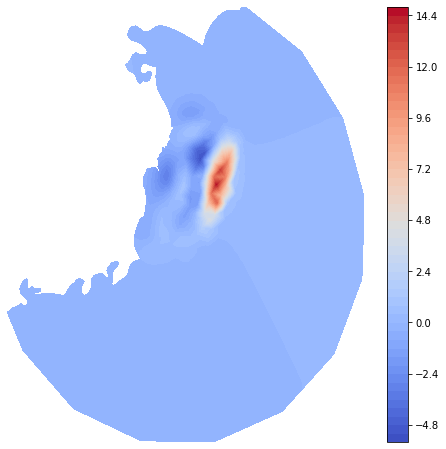

In [12]:
fig, axes = plt.subplots(figsize=(8, 8))
eta = swp.fwd_solutions[0].split()[1].copy(deepcopy=True)
fig.colorbar(tricontourf(eta, axes=axes, **plotting_kwargs), ax=axes);
axes.axis(False);

Store the initial condition so that it may be interpreted as a control by `pyadjoint` and then solve forward.

In [ ]:
source_control = Control(swp.fwd_solutions[0])
swp.setup_solver_forward(0)
swp.solve_forward_step(0)
print("QoI: {:.4e}".format(op_opt.J))

Compute the gradient and extract the adjoint solution at time $t=0$.

In [ ]:
swp.compute_gradient(source_control)
swp.get_solve_blocks()
swp.extract_adjoint_solution(0)
u_star, eta_star = swp.adj_solutions[0].split()

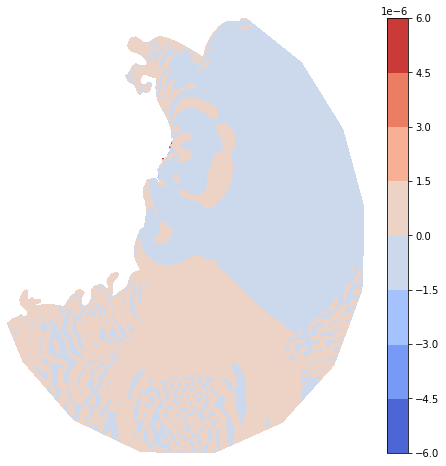

In [15]:
fig, axes = plt.subplots(figsize=(8, 8))
fig.colorbar(tricontourf(eta_star, axes=axes, cmap='coolwarm'), ax=axes);
axes.axis(False);

### Differentate the source model

In [70]:
op_opt.get_seed_matrices()
F, dFdm = adolc.fov_forward(tape_tag, op_opt.input_vector, op_opt.seed_matrices)
N = op.N
F = F.reshape(190, N, N)
F = sum(F[i, :, :] for i in range(190))
dFdm = dFdm.reshape(190, N, N, 4)

In [71]:
dFdm.shape

(190, 51, 51, 4)

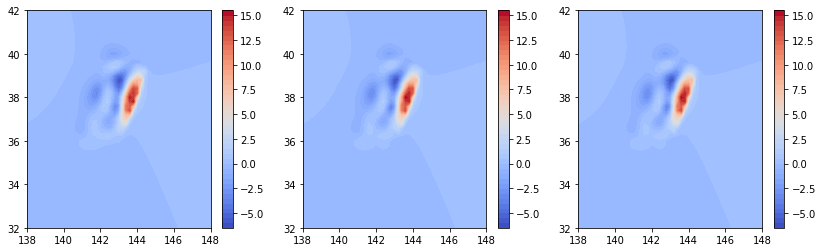

In [18]:
fig, axes = plt.subplots(ncols=3, figsize=(14, 4))
X = op.fault.dtopo.X
Y = op.fault.dtopo.Y
fig.colorbar(axes[0].contourf(X, Y, op.fault.dtopo.dZ.reshape(N, N), **plotting_kwargs), ax=axes[0]);
fig.colorbar(axes[1].contourf(X, Y, op_opt.fault.dtopo.dZ.reshape(N, N), **plotting_kwargs), ax=axes[1]);
fig.colorbar(axes[2].contourf(X, Y, F.reshape(N, N), **plotting_kwargs), ax=axes[2]);

### Establish interpolation operator from Okada grid to mesh

Creating the Okada mesh is easy: just use `Firedrake`'s utility meshes.
Note that the first two arguments to `SquareMesh` are the number of *cells* in each direction, whereas `N` is the number of *vertices*.

In [61]:
quads = False
okada_mesh = SquareMesh(N-1, N-1, 10, 10, quadrilateral=quads)
okada_mesh.coordinates.dat.data[:] += [138, 32]

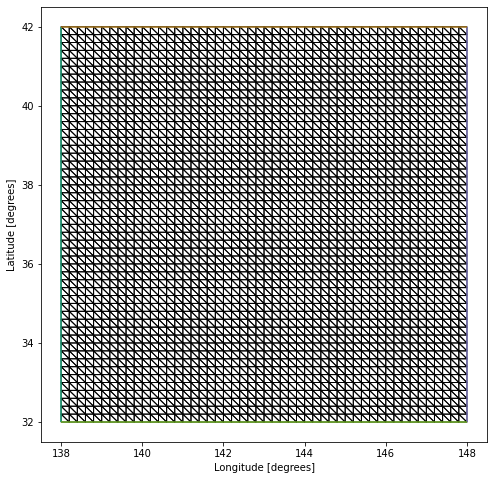

In [62]:
fig, axes = plt.subplots(figsize=(8, 8))
triplot(okada_mesh, axes=axes);
axes.set_xlabel("Longitude [degrees]");
axes.set_ylabel("Latitude [degrees]");

Create source and target spaces

In [63]:
P1_okada = FunctionSpace(okada_mesh, "CG", 1)
P1_lonlat = FunctionSpace(op.lonlat_mesh, "CG", 1)

 Create source and target images and a `libsupermesh` projector between them

In [64]:
source = Function(P1_okada, name="Source")
target = Function(P1_lonlat, name="Target")
proj = firedrake.projection.SupermeshProjector(source, target)

Establish an index mapping between the logical $x$ and $y$ directions and the ordering used by `Firedrake` for the Okada mesh.

In [65]:
X = np.linspace(0, N, N)
x_locations = []
y_locations = []
for i, coord in enumerate(okada_mesh.coordinates.dat.data):
    x_locations.append(int(np.round((coord[0] - 138)*(N-1)/10)))
    y_locations.append(int(np.round((coord[1] - 32)*(N-1)/10)))

In [66]:
def field_from_array(arr):
    """Insert an array `arr` into the source image."""
    for k in range(N*N):
        source.dat.data[k] = arr[y_locations[k], x_locations[k]]

Now we can interpolate between the Okada grid and the mesh used for solving the shallow water problem.
First, let's try interpolating the image of the Okada model:

In [67]:
field_from_array(F)
proj.project();

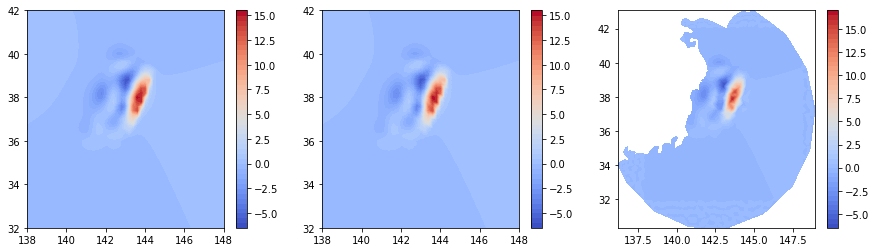

In [68]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 4))

fig.colorbar(axes[0].contourf(op.fault.dtopo.X, op.fault.dtopo.Y, F, **plotting_kwargs), ax=axes[0]);
fig.colorbar(tricontourf(source, axes=axes[1], **plotting_kwargs), ax=axes[1]);
fig.colorbar(tricontourf(target, axes=axes[2], **plotting_kwargs), ax=axes[2]);

We expect the first and second plots to be identical.
They are *almost* identical.
It seems that the difference is actually a plotting artefact.
If you go back and set `quads = True` then there is almost no difference.

### Applying the chain rule

We are now set to be able to compute the gradient of $J$ with respect to the Okada parameters!

Component of dJdm: -8.9298e-01
Component of dJdm: 4.9693e-02
Component of dJdm: -4.6405e-02
Component of dJdm: -6.3259e-02


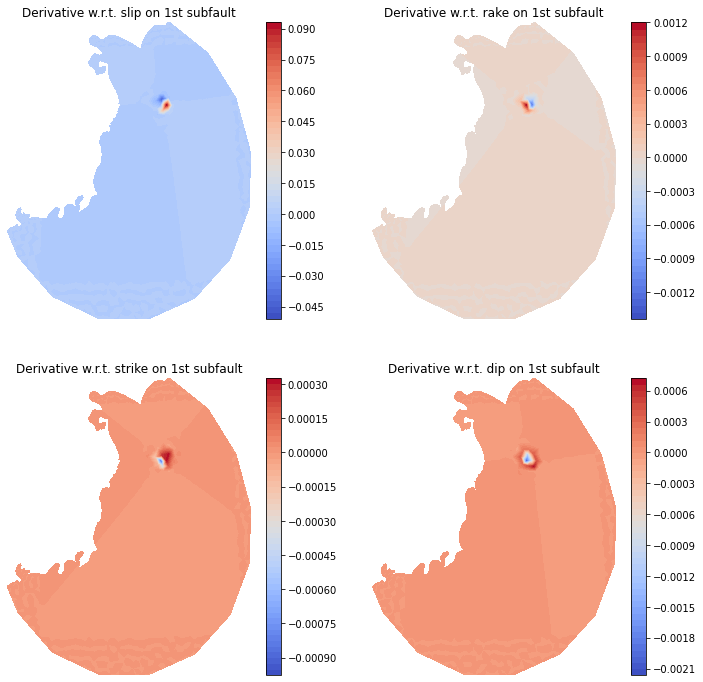

In [79]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12, 12))

deta0dm = Function(swp.P1[0])
for i in range(4):
    field_from_array(dFdm[0, :, :, i])
    proj.project();
    
    deta0dm.dat.data[:] = target.dat.data  # Copy from longitude-latitude mesh to UTM mesh
    
    ax = axes[i // 2, i % 2]
    fig.colorbar(tricontourf(deta0dm, axes=ax, **plotting_kwargs), ax=ax);
    ax.set_title("Derivative w.r.t. {:s} on 1st subfault".format(op.active_controls[i]));
    ax.axis(False);
    
    print("Component of dJdm: {:.4e}".format(assemble(eta_star*deta0dm*dx)))

In [81]:
dJdm = np.zeros((op.nx*op.ny, 4))
for j in range(4):
    for i in range(op.nx*op.ny):
        field_from_array(dFdm[i, :, :, j])
        proj.project();
        deta0dm.dat.data[:] = target.dat.data
        dJdm[i, j] = assemble(eta_star*deta0dm*dx)

In [82]:
print(dJdm)

[[-8.92975208e-01  4.96931529e-02 -4.64050329e-02 -6.32588287e-02]
 [-1.03366749e+00 -6.47191455e-02  9.07378606e-02  1.10574128e-01]
 [-5.07667366e+00 -1.21529761e-01  1.44871683e-01  2.80578383e-02]
 [-9.22359822e+00 -1.60818040e+00  1.71465778e+00  2.21991018e+00]
 [-1.09638676e+01 -4.14752297e+00  2.13746527e+00  1.15938006e+01]
 [-5.68249833e+00 -1.88543334e+00  5.27590975e+00  2.42907854e+01]
 [-6.59507767e+00  5.48341662e-01 -5.13939287e+00  2.69349272e+01]
 [-7.30171480e+00  3.29933690e+00 -1.39773746e+00  2.18536610e+01]
 [-1.21236131e+01  4.14738287e+00 -3.16415556e+00  1.58546502e+01]
 [-1.12659385e+01  5.28647980e+00 -4.97493413e+00  6.87227365e+00]
 [-8.49637192e+00  2.53883621e+00 -3.95679854e+00 -7.43135323e+00]
 [-4.44304928e+00  4.04123582e-01 -5.29488977e-01 -3.53092595e+00]
 [-9.69783787e-01 -4.20098729e-01 -2.63560565e-02 -3.22644756e+00]
 [-7.76479102e-01 -2.54324834e-01 -1.42310269e-03 -1.07308478e+00]
 [ 5.04676667e-01 -6.40820647e-02 -3.67135054e-02 -4.59946004e

There we have it: the gradient of the timeseries misfit QoI with respect to an array of slip, rake, strike and dip parameters!
We can now use it in gradient-based optimisation routines for source inversion.